In [2]:
%load_ext autoreload
%autoreload 2

In [93]:
import os 
import sys
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report
import pprint
pp = pprint.PrettyPrinter(indent = 4)
import churn_config as cfg
import churn_library as cls

print(np.__version__, sns.__version__)

1.20.3 0.11.2


In [94]:
input_file = os.path.join(cfg.INPUT_PATH, cfg.INPUT_FILE)
df = cls.import_data(input_file)
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


In [45]:
# df = pd.read_csv(conf.input_file)
# df.head()


# df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

In [95]:
print('Data frame shape:', df.shape)
print()

print(f"{'column_name':35}  {'data type':20}     {'# of null entires':20}")
print(f"{'-'*35:35}  {('-'*20):20}     {'-'*20:20}")
for col in df.columns:
    print(f"{col:35}  {str(df[col].dtype):20}     {df[col].isnull().sum():6d}")


Data frame shape: (10127, 23)

column_name                          data type                # of null entires   
-----------------------------------  --------------------     --------------------
Unnamed: 0                           int64                         0
CLIENTNUM                            int64                         0
Attrition_Flag                       object                        0
Customer_Age                         int64                         0
Gender                               object                        0
Dependent_count                      int64                         0
Education_Level                      object                        0
Marital_Status                       object                        0
Income_Category                      object                        0
Card_Category                        object                        0
Months_on_book                       int64                         0
Total_Relationship_Count             int64  

In [96]:
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.160660
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.367235
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,1.000000


In [76]:
# cat_columns = [
#     'Gender',
#     'Education_Level',
#     'Marital_Status',
#     'Income_Category',
#     'Card_Category'                
# ]

# quant_columns = [
#     'Customer_Age',
#     'Dependent_count', 
#     'Months_on_book',
#     'Total_Relationship_Count', 
#     'Months_Inactive_12_mon',
#     'Contacts_Count_12_mon', 
#     'Credit_Limit', 
#     'Total_Revolving_Bal',
#     'Avg_Open_To_Buy', 
#     'Total_Amt_Chng_Q4_Q1', 
#     'Total_Trans_Amt',
#     'Total_Trans_Ct', 
#     'Total_Ct_Chng_Q4_Q1', 
#     'Avg_Utilization_Ratio'
# ]

In [98]:
pp.pprint(cfg.CAT_COLUMNS)
print()
pp.pprint(cfg.QUANT_COLUMNS)

[   'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category']

[   'Customer_Age',
    'Dependent_count',
    'Months_on_book',
    'Total_Relationship_Count',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio']


## EDA Plots

0

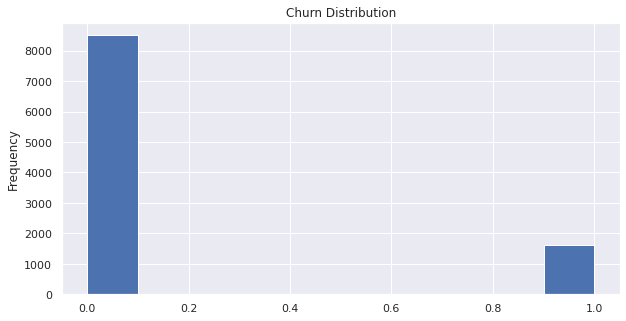

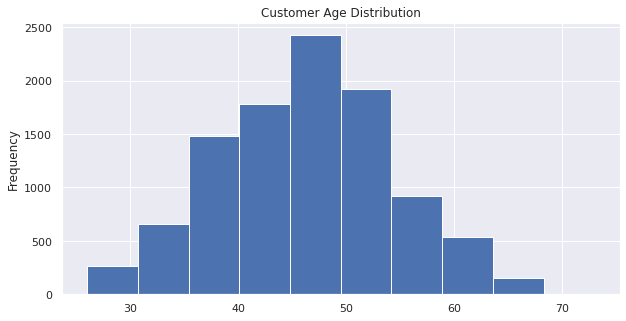

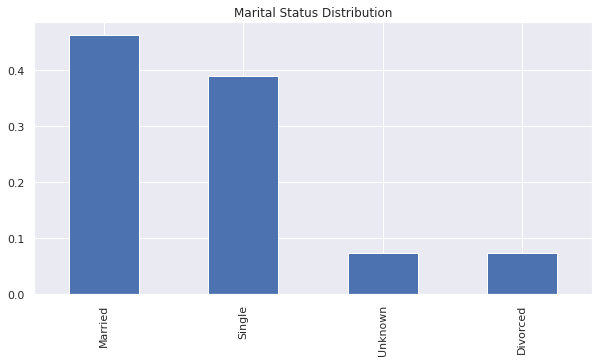

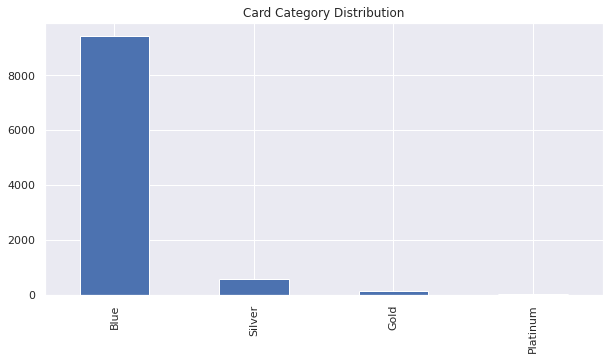

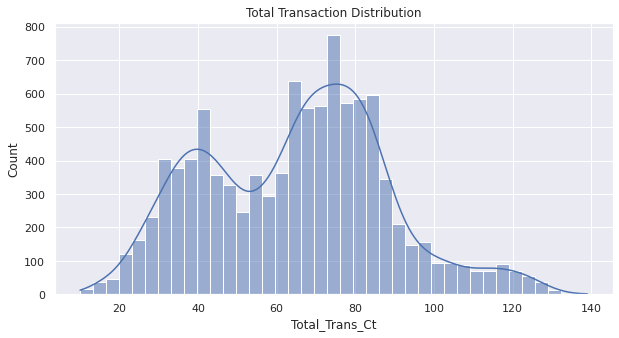

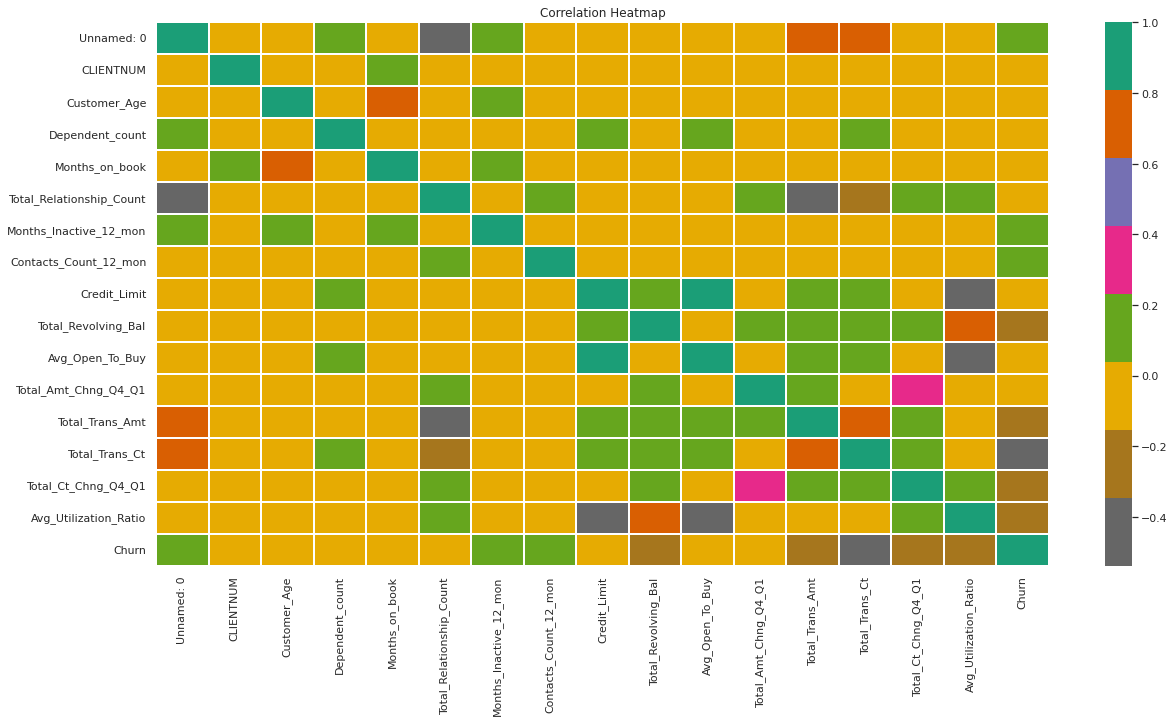

In [99]:
cls.perform_eda(df)

### Churn Distribution Histogram

ERROR 1: ("savefig() missing 1 required positional argument: 'fname'",)
(<class 'TypeError'>, TypeError("savefig() missing 1 required positional argument: 'fname'"), <traceback object at 0x7f27a9b45fc0>)


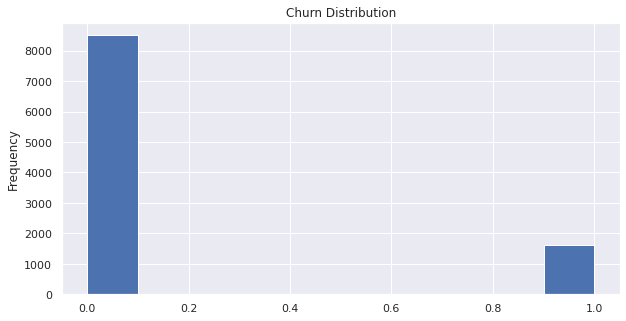

In [63]:
import traceback 
fig = plt.figure(figsize=(10,5)) 
# ax = fig.ax
hist = df['Churn'].plot.hist( fig = fig, title = "Churn Distribution");
# fig.savefig(os.path.join('./images/eda','churn_distribution.png'))  
# fig.savefig()    
try:
    fig.savefig()    
except TypeError as excp:
    print(f"ERROR 1: {excp.args}")
except Exception as e:
    print(f"ERROR 2: {sys.exc_info()}")


### Customer Age Distribution Histogram

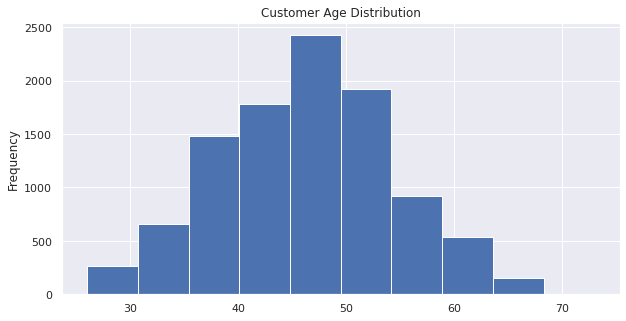

In [11]:
plt.figure(figsize=(10,5)) 
df['Customer_Age'].plot.hist(title = "Customer Age Distribution");
fig.savefig(os.path.join('./images/eda','customer_age_distribution.png'))    


### Card Category Distribution Histogram

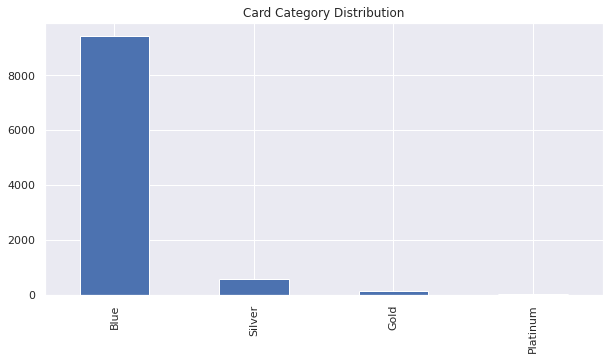

In [43]:
fig = plt.figure(figsize=(10,5)) 
df.Card_Category.value_counts().plot(kind='bar', fig = fig, title = "Card Category Distribution")
fig.savefig(os.path.join('./images/eda','card_category_distribution.png'))    


### Marital Status Distribution Histogram

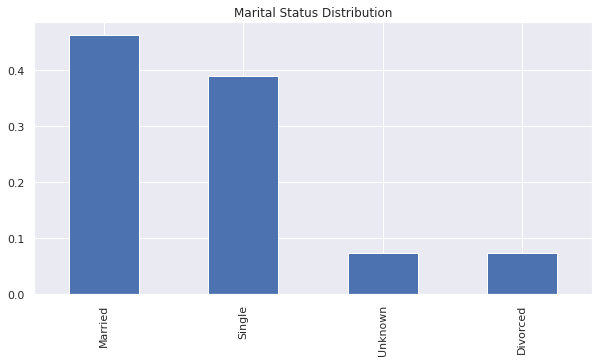

In [45]:
fig = plt.figure(figsize=(10,5)) 
df.Marital_Status.value_counts('normalize').plot(kind='bar', fig = fig, title = "Marital Status Distribution");
fig.savefig(os.path.join('./images/eda','marital_status_distribution.png'))

### Transaction Count Distribution

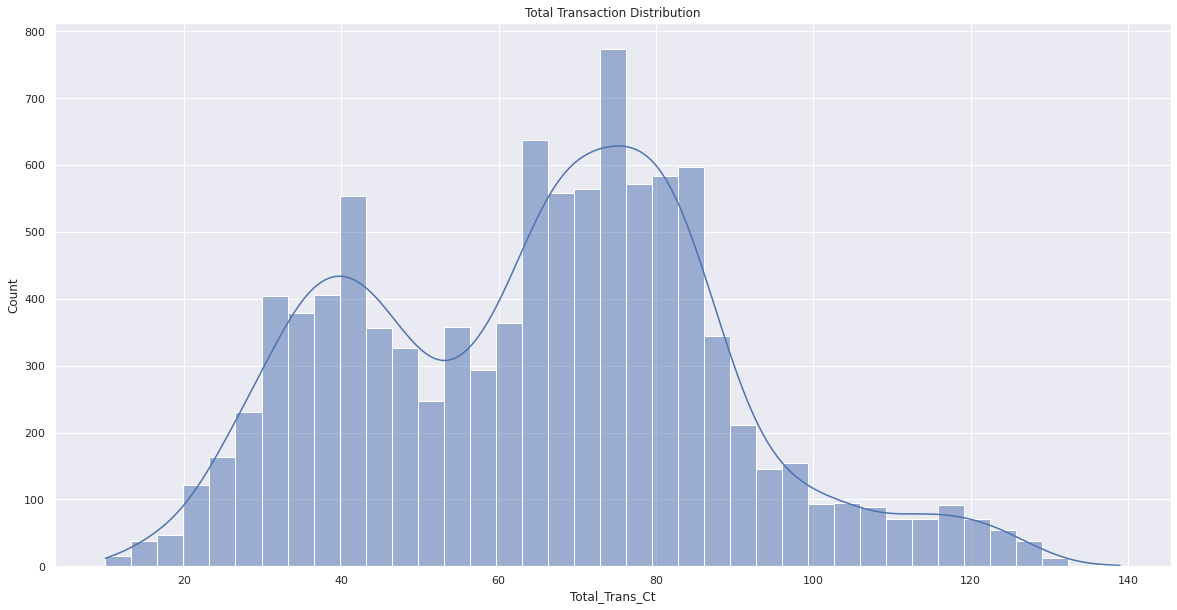

In [33]:
plt.figure(figsize=(20,10)) 
sns.histplot(df['Total_Trans_Ct'], kde = True).set_title('Total Transaction Distribution');
# fig.savefig(os.path.join('./images/eda','total_transaction_distribution.png'))

plt.savefig(os.path.join('./images/eda','total_transaction_distribution.png'))

### Correlation Distribution

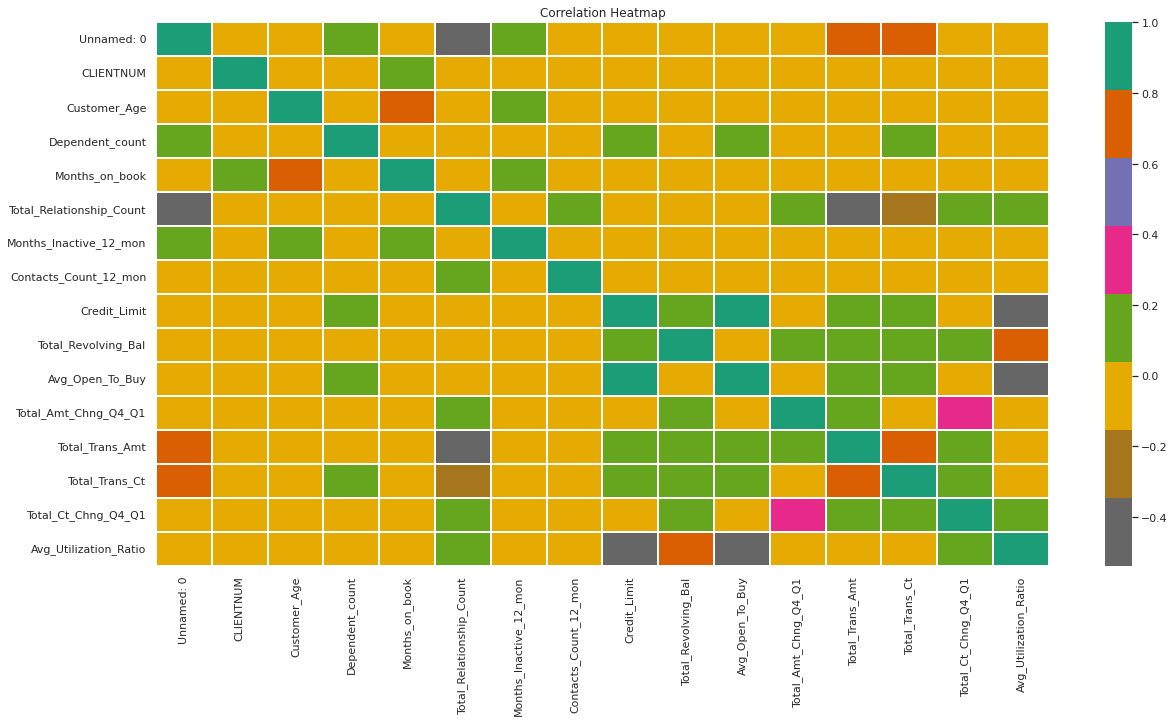

In [34]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2).set_title("Correlation Heatmap")
plt.savefig(os.path.join('./images/eda','correlation_heatmap.png'))

In [55]:
# gender encoded column
gender_groups = df.groupby('Gender').mean()['Churn']
print(gender_groups)
print()

edu_groups = df.groupby('Education_Level').mean()['Churn']
print(edu_groups)
print()

marital_groups = df.groupby('Marital_Status').mean()['Churn']
print(marital_groups)
print()

income_groups = df.groupby('Income_Category').mean()['Churn']
print(income_groups)
print()

card_groups = df.groupby('Card_Category').mean()['Churn']
print(card_groups)

Gender
F    0.173572
M    0.146152
Name: Churn, dtype: float64

Education_Level
College          0.152024
Doctorate        0.210643
Graduate         0.155691
High School      0.152012
Post-Graduate    0.178295
Uneducated       0.159381
Unknown          0.168532
Name: Churn, dtype: float64

Marital_Status
Divorced    0.161765
Married     0.151269
Single      0.169414
Unknown     0.172230
Name: Churn, dtype: float64

Income_Category
$120K +           0.173315
$40K - $60K       0.151397
$60K - $80K       0.134807
$80K - $120K      0.157655
Less than $40K    0.171862
Unknown           0.168165
Name: Churn, dtype: float64

Card_Category
Blue        0.160979
Gold        0.181034
Platinum    0.250000
Silver      0.147748
Name: Churn, dtype: float64


## Generate Chrun Numerical Proportion for categorical columns 

In [100]:
df_encoded = cls.encoder_helper(df)

In [101]:
print(df_encoded.columns)

Index(['Unnamed: 0', 'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn', 'Gender_Churn', 'Education_Level_Churn',
       'Marital_Status_Churn', 'Income_Category_Churn', 'Card_Category_Churn'],
      dtype='object')


In [21]:
# print(df.columns)

Index(['Unnamed: 0', 'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn', 'Gender_Churn', 'Education_Level_Churn',
       'Marital_Status_Churn', 'Income_Category_Churn', 'Card_Category_Churn'],
      dtype='object')


In [90]:
# # gender encoded column
# gender_lst = []
# gender_groups = df.groupby('Gender').mean()['Churn']

# for val in df['Gender']:
#     gender_lst.append(gender_groups.loc[val])

# df['Gender_Churn'] = gender_lst    

# #education encoded column
# edu_lst = []
# edu_groups = df.groupby('Education_Level').mean()['Churn']

# for val in df['Education_Level']:
#     edu_lst.append(edu_groups.loc[val])

# df['Education_Level_Churn'] = edu_lst

# #marital encoded column
# marital_lst = []
# marital_groups = df.groupby('Marital_Status').mean()['Churn']

# for val in df['Marital_Status']:
#     marital_lst.append(marital_groups.loc[val])

# df['Marital_Status_Churn'] = marital_lst

# #income encoded column
# income_lst = []
# income_groups = df.groupby('Income_Category').mean()['Churn']

# for val in df['Income_Category']:
#     income_lst.append(income_groups.loc[val])

# df['Income_Category_Churn'] = income_lst

# #card encoded column
# card_lst = []
# card_groups = df.groupby('Card_Category').mean()['Churn']
 
# for val in df['Card_Category']:
#     card_lst.append(card_groups.loc[val])

# df['Card_Category_Churn'] = card_lst
    
    

In [21]:
# print(df.columns)

Index(['Unnamed: 0', 'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn', 'Gender_Churn', 'Education_Level_Churn',
       'Marital_Status_Churn', 'Income_Category_Churn', 'Card_Category_Churn'],
      dtype='object')


### Remove categorical columns and produce training and test files

In [103]:
pp.pprint(cfg.RESPONSE_COL)
pp.pprint(cfg.KEEP_COLS)


'Churn'
[   'Customer_Age',
    'Dependent_count',
    'Months_on_book',
    'Total_Relationship_Count',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio',
    'Gender_Churn',
    'Education_Level_Churn',
    'Marital_Status_Churn',
    'Income_Category_Churn',
    'Card_Category_Churn']


In [104]:
X_train, X_test, y_train, y_test = cls.perform_feature_engineering(df_encoded, keep_columns = cfg.KEEP_COLS, response = cfg.RESPONSE_COL)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7088, 19) (3039, 19) (7088,) (3039,)


In [ ]:
# keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
#              'Total_Relationship_Count', 'Months_Inactive_12_mon',
#              'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
#              'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
#              'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
#              'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
#              'Income_Category_Churn', 'Card_Category_Churn']

In [ ]:
# X = pd.DataFrame()

# X[keep_cols] = df[keep_cols]
# y = df['Churn']
# print(f"Removed Columns : {set(df.columns) - set(X.columns)}")
# X.head()

In [22]:
# train test split 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Build models 

In [109]:
rf_model , lr_model = cls.train_models(X_train, X_test, y_train, y_test)

 Random Forest Parameter Grid Search Starts . . . 
 Random Forest Parameter Grid Search Completed Fitting Starts . . . 
 Random Forest Fitting Starts . . . 
 Random Forest Fitting Complete . . . 
 Logisitic Regression Fitting Starts . . . 
 Logisitic Regression Fitting Complete . . . 
 Store Trained Models . . . 


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


 Store Trained Models Complete. . . 
 Get model predictions . . . 
 Get model predictions Complete. . . 
 Generate Model Performance Reports...


Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.


 Generate Model Performance Reports Complete...


In [73]:

# # grid search
# rfc = RandomForestClassifier(random_state=42)
# lrc = LogisticRegression()

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth' : [4,5,100],
#     'criterion' :['gini', 'entropy']
# }

# cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# cv_rfc.fit(X_train, y_train)

# lrc.fit(X_train, y_train)

In [ ]:
# rfc train and test predicitons
# y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
# y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)


### Load models and display performance information

In [30]:
# rf_model = joblib.load('./models/rfc_model.pkl')
# lr_model = joblib.load('./models/logistic_model.pkl')

# print(type(rf_model))
# print(type(lr_model))

### Classification Report

In [118]:
y_train_preds_rf = rf_model.predict(X_train)
y_test_preds_rf  = rf_model.predict(X_test)

y_train_preds_lr = lr_model.predict(X_train)
y_test_preds_lr  = lr_model.predict(X_test)

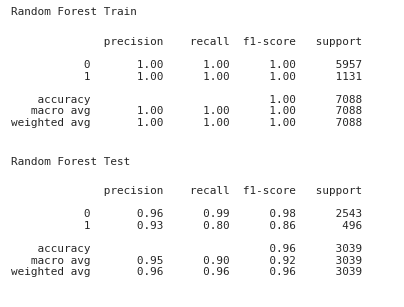

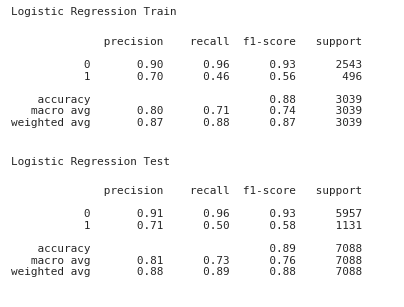

In [119]:
cls.classification_report_image(y_train,
                                y_test,
                                y_train_preds_lr,
                                y_train_preds_rf,
                                y_test_preds_lr,
                                y_test_preds_rf)

In [110]:
# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.70      0.46      0.56       496

    accuracy                           0.88      3039
   macro avg       0.80      0.71     

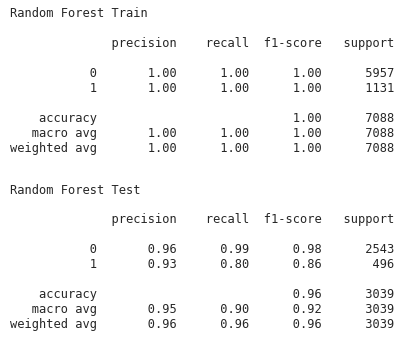

In [111]:
plt.rc('figure', figsize=(5, 5))
fontsize = 12
# plt.text(0.01, 0.05, str(model.summary()), {'fontsize': forsize})   ## old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': fontsize}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': fontsize}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': fontsize}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': fontsize}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


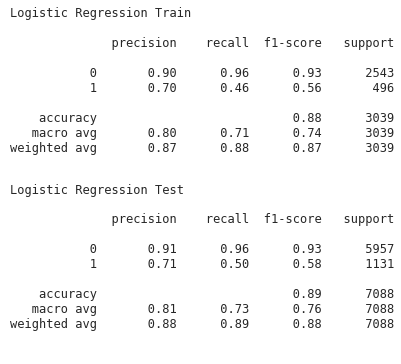

In [112]:
plt.rc('figure', figsize=(5, 5))
fontsize = 12
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': fontsize}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': fontsize}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': fontsize}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': fontsize}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');

### Plot ROC curves

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.


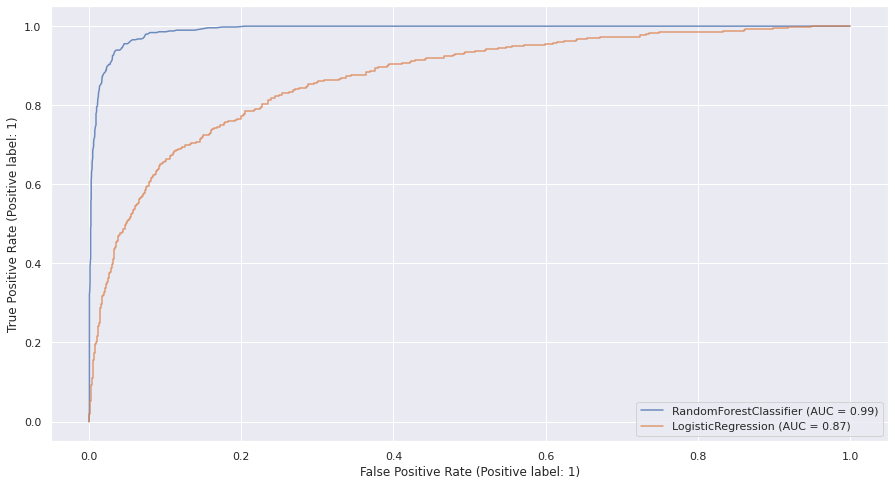

In [113]:
cls.roc_plots([rfc_model, lr_model], X_test, y_test)

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.


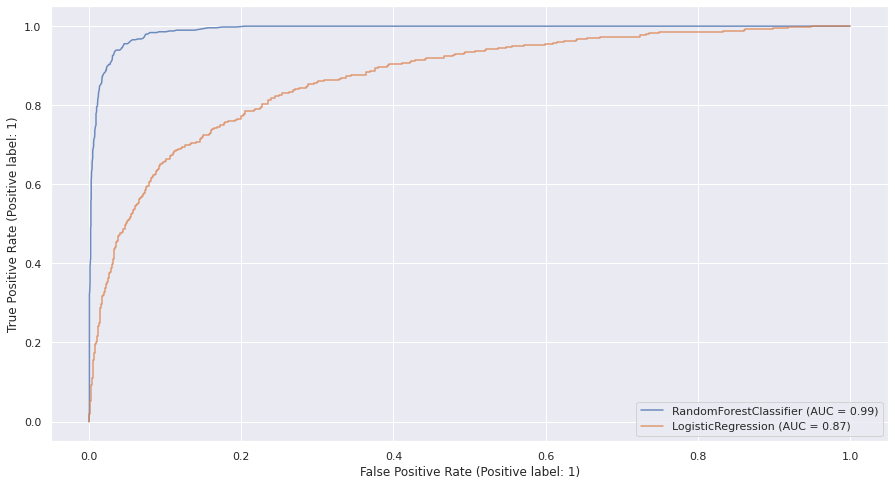

In [149]:
# plt.figure(figsize=(15, 8))
# lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rf_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot = plot_roc_curve(lr_model, X_test, y_test, ax = ax, alpha = 0.8)
plt.show()

###  Shap Explainer

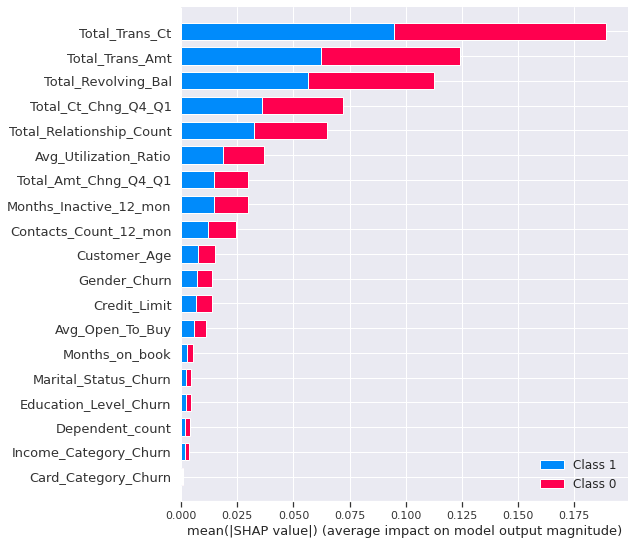

In [25]:
# explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
explainer = shap.TreeExplainer(rfc_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Feature Importance Plot

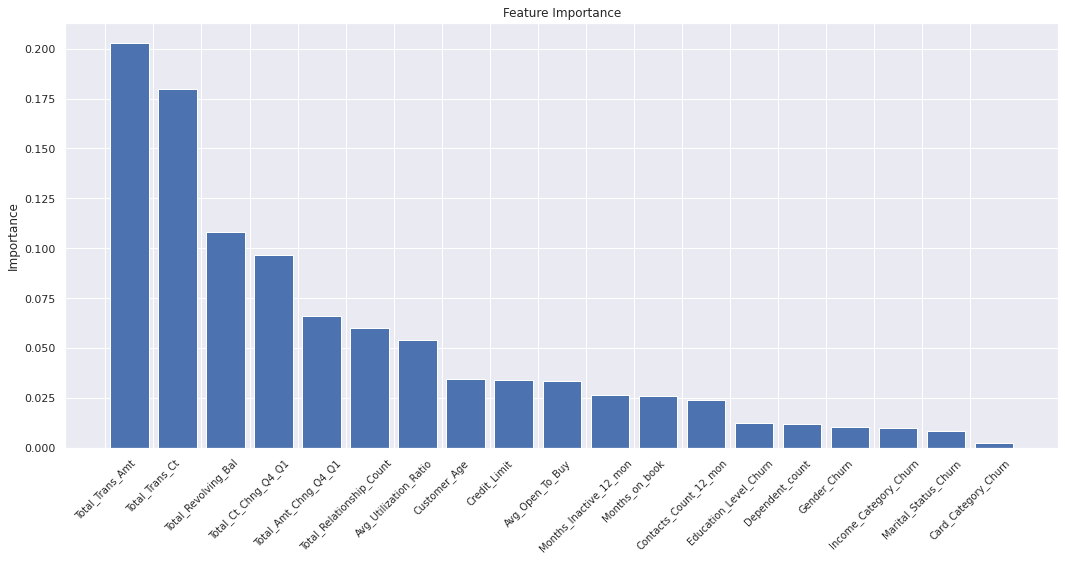

In [116]:
 
cls.feature_importance_plot(rfc_model, X_test)
 

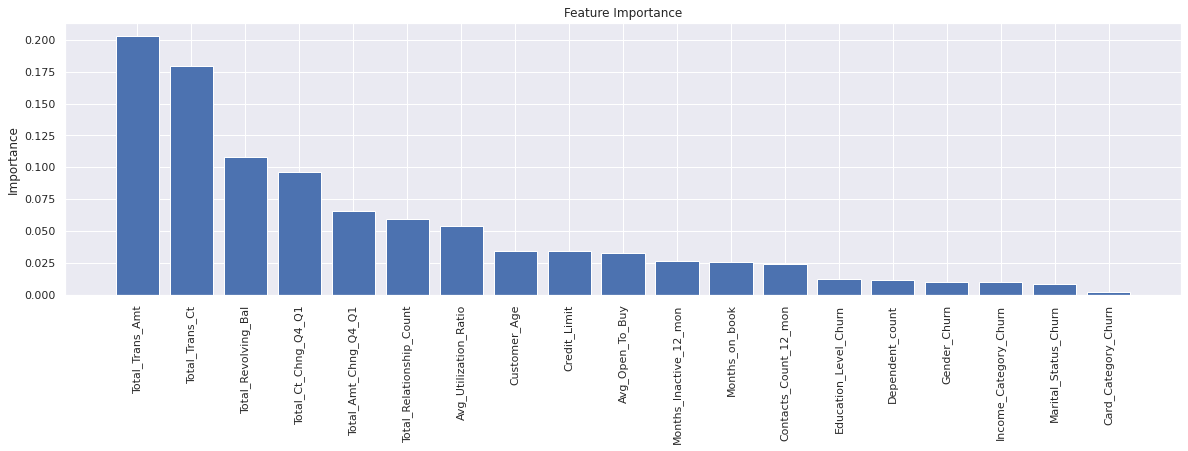

In [117]:
# Calculate feature importances
# importances = cv_rfc.best_estimator_.feature_importances_
importances = rf_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);